In [1]:

import numpy as np
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import Functions_plotting as fp
import xarray as xr
import xmitgcm
import matplotlib.path as mpath
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
from Datasets import exp_set_dict_warm_order, exp_set_dict_wind_order
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Load wind, T datasets --------------------------------

data_dir = 'Saved Arrays/Ensemble_data/'
vnames = ['uwind','vwind','T'] #'T' or 'atemp' works #this indexing is important. don't change.
f_vnames = ['uwind','vwind','T_400m']
da_list = [] #propagate data in order of vnames
exp_set = 'ic_2001' #all forcings are same regardless of exp set

for vname, f_vname in zip(vnames, f_vnames):
    fname = data_dir + f_vname + '_'+exp_set+'_full_model_domain_60_months.nc'
    print(vname, fname)
    try:
        ds = xr.open_dataset(fname)
        da = ds[vname]
        print(fname, 'found')
        
    except FileNotFoundError:
        runs = exp_set_dict_warm_order[exp_set]
        print('Using the following experiments in this order:\n',runs)
        print(fname,'not found, saved new .nc file! with runs in this order:',runs)
        try:
            da = fda.get_ensemble_data_for_ic(vname, runs, 'full_model_domain', 'EXF_forcing_set2', n_months = 60) 
        except:
            da = fda.get_ensemble_data_for_ic(vname, runs, 'full_model_domain',  'state_3d_set2', n_months = 60) 
        # print(da)
        ds = da.to_dataset(name = vname)
        ds.to_netcdf(fname)
        
    da_list.append(da)

# Select year-mean and select plotting region--------------------------------

plot_region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[plot_region]
ann_mean_da_list = [] #follows vname order
for da in da_list:
    da_yr5 = da.isel(time=slice(47,59))
    da_yr5_mean = da_yr5.mean(dim='time')
    da_reg = da_yr5_mean.sel(lat = slice(lat1, lat2), lon = slice(lon1, lon2))
    ann_mean_da_list.append(da_reg)

# Get ens means
uwind_em = ann_mean_da_list[0].mean(dim = 'run')
vwind_em = ann_mean_da_list[1].mean(dim = 'run')  
T_em = ann_mean_da_list[2].mean(dim = 'run')  

# Get anoms
uwind_anom = ann_mean_da_list[0] - uwind_em #shape (n_runs, n_lats,n_lons)
vwind_anom = ann_mean_da_list[1] - vwind_em
T_anom = ann_mean_da_list[2] - T_em

#Calculate composites
warm_comp_T_runs = T_anom.isel(run = slice(0,4))
warm_comp_T = warm_comp_T_runs.mean(dim='run')
warm_comp_uwind_runs = uwind_anom.isel(run=slice(0,4))
warm_comp_uwind = warm_comp_uwind_runs.mean(dim='run')
warm_comp_vwind_runs = vwind_anom.isel(run=slice(0,4))
warm_comp_vwind = warm_comp_vwind_runs.mean(dim='run')
print('warm composite runs:',warm_comp_T_runs.run.values)

cool_comp_T_runs = T_anom.isel(run = slice(4,8))
cool_comp_T = cool_comp_T_runs.mean(dim='run')
cool_comp_uwind_runs = uwind_anom.isel(run=slice(4,8))
cool_comp_uwind = cool_comp_uwind_runs.mean(dim='run')
cool_comp_vwind_runs = vwind_anom.isel(run=slice(4,8))
cool_comp_vwind = cool_comp_vwind_runs.mean(dim='run')
print('cool composite runs:',cool_comp_T_runs.run.values)

uwind Saved Arrays/Ensemble_data/uwind_ic_2001_full_model_domain_60_months.nc
Saved Arrays/Ensemble_data/uwind_ic_2001_full_model_domain_60_months.nc found
vwind Saved Arrays/Ensemble_data/vwind_ic_2001_full_model_domain_60_months.nc
Saved Arrays/Ensemble_data/vwind_ic_2001_full_model_domain_60_months.nc found
T Saved Arrays/Ensemble_data/T_400m_ic_2001_full_model_domain_60_months.nc
Saved Arrays/Ensemble_data/T_400m_ic_2001_full_model_domain_60_months.nc found
warm composite runs: ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
cool composite runs: ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


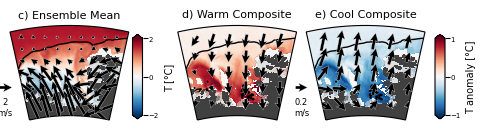

In [14]:
# Plot winds and T

color_data = [T_em, warm_comp_T, cool_comp_T]
x_data = [uwind_em, warm_comp_uwind, cool_comp_uwind]
y_data = [vwind_em, warm_comp_vwind, cool_comp_vwind]
T_lims = [2,1,1]
q_scales = [18,2,2]
regrids = [9,7.6,7.6]
titles = ['c) Ensemble Mean', 'd) Warm Composite','e) Cool Composite']

fig = plt.figure()
fig.set_size_inches((5,1.3))
# Create GridSpec with extra columns for colorbars
gs = GridSpec(1, 4, width_ratios=[1, 0.25, 1, 1], wspace=0.1)

lons, lats = color_data[0].lon, color_data[0].lat
lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()
land_ice_ds = fda.get_bathymetry_and_troughs()

axes = []
cf_maps = []
j = 0 # count data indexes
for i in range(4):

    if i == 1:
        # empty spot for ens mean colorbar
        ax = fig.add_subplot(gs[0,i])
        ax.set_visible(False)
    else:
        ax = fig.add_subplot(gs[0,i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
        color_data_j = color_data[j]
        x_data_j = x_data[j]
        y_data_j = y_data[j]
    
        cf = ax.pcolormesh(lons, lats, color_data_j, vmin=-T_lims[j], vmax=T_lims[j],
                           transform=grid_proj, cmap='RdBu_r', zorder=0)
        cf_maps.append(cf)
        quiv = ax.quiver(lons, lats, x_data_j, y_data_j, transform = grid_proj, 
                         regrid_shape=regrids[j], pivot = 'middle', scale=q_scales[j], width=0.025, headlength=3,
                         headaxislength=2.5, minshaft=1, edgecolor='white',linewidth = 0.2,zorder=3)
        if i == 0:
            vec_len = 2
            ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s', 
                         labelpos='S', fontproperties={'size': 6})
        elif i == 3:
            vec_len = 0.2
            ax.quiverkey(quiv, X=-0.04, Y=0.35, U=vec_len, label=str(vec_len)+'\nm/s', 
                         labelpos='S', fontproperties={'size': 6})
        ax.set_title(titles[j], fontsize=8)
        
        j += 1
        axes.append(ax)
        
for ax in axes:
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1000,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


# Add colorbars
cb_ax1 = fig.add_axes([0.295,0.12,0.02,0.65])
cb1 = fig.colorbar(cf_maps[0], cax=cb_ax1, extend='both',orientation = 'vertical')  
cb1.set_label(label = 'T [°C]', fontsize=7)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([-2,0,2])

cb_ax2 = fig.add_axes([0.9,0.12,0.02,0.65])
cb2 = fig.colorbar(cf_maps[2], cax=cb_ax2, extend='both',orientation = 'vertical')  
cb2.set_label(label = 'T anomaly [°C]', fontsize=7)
cb2.ax.tick_params(labelsize=5,pad=0.5)
cb2.set_ticks([-1,0,1])


fig.subplots_adjust(left=0.05,right=0.88,top=0.9,bottom=0.05,wspace=0.1,hspace=.05)

plt.savefig('Plots/Figure_2cde_winds_T.png',dpi=400)

In [109]:
# Get SIA data for specified season

# season = 'winter'
season = 'spring'

# Get all 60 months of data in all 10 runs
fname = 'Saved Arrays/Ensemble_data/SIarea_'+exp_set+'_full_model_domain_60_months.nc'
try:
    ds = xr.open_dataset(fname)
    sia_da = ds.SIarea
    print(fname, 'found')
except FileNotFoundError:
    sia_da = fda.get_ensemble_data_for_ic('SIarea', runs, 'full_model_domain',  'state_2d_set2', n_months = 60) 
    ds = sia_da.to_dataset(name = 'SIarea')
    ds.to_netcdf(fname)
    print(fname,'not found, saved new .nc file!')

# Select region 
sia_da_reg = sia_da.sel(lat = slice(lat1,lat2), lon = slice(lon1,lon2))

# Select seasonal data (in all 5yrs)
seas_dict = {'winter':[6,7,8],
             'spring':[9,10,11],
             'summer':[12,1,2],
             'fall':[3,4,5] }
seas_sia_da = sia_da_reg.sel(time=sia_da_reg['time'].dt.month.isin(seas_dict[season]))

# # Get ensemble mean in season for all 5 years
seas_sia_da_5yr_mean = seas_sia_da.mean(dim='time')
seas_sia_em_5yr = seas_sia_da_5yr_mean.mean(dim='run') #shape (n_lats, n_lons)

# # Calc anoms in year 5 season relative to 5-year seasonal mean
seas_sia_da_yr5_mean = seas_sia_da.mean(dim='time') 
seas_sia_yr5_anom = seas_sia_da_yr5_mean - seas_sia_em_5yr #shape (n_runs, n_lats, n_lons)

# get warm and cool composites for 5th yr seasonal mean in anomalies rel to yr1 seas mean
warm_sia_yr5_runs = seas_sia_yr5_anom.isel(run=slice(0,4))
warm_sia_yr5_anom = warm_sia_yr5_runs.mean(dim='run')
cool_sia_yr5_runs = seas_sia_yr5_anom.isel(run=slice(4,8))
cool_sia_yr5_anom = cool_sia_yr5_runs.mean(dim='run')
print('warm runs',warm_sia_yr5_runs.run.values)
print('cool runs',cool_sia_yr5_runs.run.values)


Saved Arrays/Ensemble_data/SIarea_ic_2001_full_model_domain_60_months.nc found
warm runs ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
cool runs ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


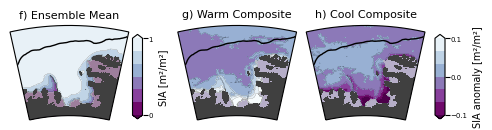

In [111]:
# Plot Sea ice

color_data = [seas_sia_em_5yr, warm_sia_yr5_anom, cool_sia_yr5_anom]
low_lims = [0,-0.1,-0.1]
hi_lims = [1,0.1,0.1]
titles = ['f) Ensemble Mean', 'g) Warm Composite','h) Cool Composite']
# colors = ["780000","ac413d","df817a","bcc8c4","7ba0b3","447a9c"]

# colors = ['#'+c for c in colors[::1]]
# cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig = plt.figure()
fig.set_size_inches((5,1.3))
# Create GridSpec with extra columns for colorbars
gs = GridSpec(1, 4, width_ratios=[1, 0.25, 1, 1], wspace=0.1)

lons, lats = color_data[0].lon, color_data[0].lat
lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

axes = []
cf_maps = []
j = 0 # count data indexes
for i in range(4):

    if i == 1:
        # empty spot for ens mean colorbar
        ax = fig.add_subplot(gs[0,i])
        ax.set_visible(False)
    else:
        ax = fig.add_subplot(gs[0,i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
        color_data_j = color_data[j]
        cf = ax.contourf(lons, lats, color_data_j, levels = np.linspace(low_lims[j],hi_lims[j],7),
                         transform=grid_proj, cmap='BuPu_r', extend='both')
        ax.contour(lons,lats,color_data_j,np.linspace(low_lims[j],hi_lims[j],7),colors='k',transform=grid_proj,linewidths=0.1,zorder=1)
        cf_maps.append(cf)
        ax.set_title(titles[j], fontsize=8)
        
        j += 1
        axes.append(ax)
        
for ax in axes:
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1500,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


# Add colorbars
cb_ax1 = fig.add_axes([0.295,0.12,0.02,0.65])
cb1 = fig.colorbar(cf_maps[0], cax=cb_ax1, extend='both',orientation = 'vertical')  
cb1.set_label(label = 'SIA [m²/m²]', fontsize=7)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([low_lims[0],hi_lims[0]])

cb_ax2 = fig.add_axes([0.9,0.12,0.02,0.65])
cb2 = fig.colorbar(cf_maps[2], cax=cb_ax2, extend='both',orientation = 'vertical')  
cb2.set_label(label = 'SIA anomaly [m²/m²]', fontsize=7)
cb2.ax.tick_params(labelsize=5,pad=0.5)
cb2.set_ticks([low_lims[1],0,hi_lims[1]])


fig.subplots_adjust(left=0.05,right=0.88,top=0.9,bottom=0.05,wspace=0.1,hspace=.05)

plt.savefig('Plots/Figure_2fgh_sia_'+season+'.png',dpi=400)

In [107]:
# Get qflux data for specified season

# season = 'winter'
season = 'spring'

# Get all 60 months of data in all 10 runs
fname = 'Saved Arrays/Ensemble_data/oceQnet_'+exp_set+'_full_model_domain_60_months.nc'
try:
    ds = xr.open_dataset(fname)
    q_da = ds.oceQnet
    print(fname, 'found')
except FileNotFoundError:
    q_da = fda.get_ensemble_data_for_ic('oceQnet', runs, 'full_model_domain',  'state_2d_set2', n_months = 60) 
    ds = q_da.to_dataset(name = 'oceQnet')
    ds.to_netcdf(fname)
    print(fname,'not found, saved new .nc file!')

# Select region 
q_da_reg = q_da.sel(lat = slice(lat1,lat2), lon = slice(lon1,lon2))

# Select seasonal data (in all 5yrs)
seas_dict = {'winter':[6,7,8],
             'spring':[9,10,11],
             'summer':[12,1,2],
             'fall':[3,4,5] }
seas_q_da = q_da_reg.sel(time=q_da_reg['time'].dt.month.isin(seas_dict[season]))

# # Get ensemble mean in season for all 5 years
seas_q_da_5yr_mean = seas_q_da.mean(dim='time')
seas_q_em_5yr = seas_q_da_5yr_mean.mean(dim='run') #shape (n_lats, n_lons)

# # Calc anoms in year 5 season relative to 5-year seasonal mean
seas_q_da_yr5_mean = seas_q_da.mean(dim='time') 
seas_q_yr5_anom = seas_q_da_yr5_mean - seas_q_em_5yr #shape (n_runs, n_lats, n_lons)

# get warm and cool composites for 5th yr seasonal mean in anomalies rel to yr1 seas mean
warm_q_yr5_runs = seas_q_yr5_anom.isel(run=slice(0,4))
warm_q_yr5_anom = warm_q_yr5_runs.mean(dim='run')
cool_q_yr5_runs = seas_q_yr5_anom.isel(run=slice(4,8))
cool_q_yr5_anom = cool_q_yr5_runs.mean(dim='run')
print('warm runs',warm_q_yr5_runs.run.values)
print('cool runs',cool_q_yr5_runs.run.values)


Saved Arrays/Ensemble_data/oceQnet_ic_2001_full_model_domain_60_months.nc found
warm runs ['run_forc_erai_1982_rep_ic_2001' 'run_forc_erai_1984_rep_ic_2001'
 'run_forc_erai_1989_rep_ic_2001' 'run_forc_erai_1992_rep_ic_2001']
cool runs ['run_forc_erai_1994_rep_ic_2001' 'run_forc_erai_2003_rep_ic_2001'
 'run_forc_erai_2009_rep_ic_2001' 'run_forc_erai_1991_rep_ic_2001']


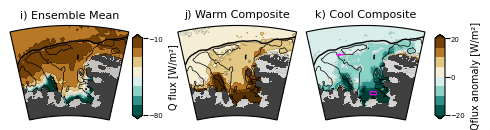

In [119]:
# Plot Qflux

color_data = [seas_q_em_5yr, warm_q_yr5_anom, cool_q_yr5_anom]
low_lims = [-80,-20,-20]
hi_lims = [-10,20,20]
titles = ['i) Ensemble Mean', 'j) Warm Composite','k) Cool Composite']


fig = plt.figure()
fig.set_size_inches((5,1.3))
# Create GridSpec with extra columns for colorbars
gs = GridSpec(1, 4, width_ratios=[1, 0.25, 1, 1], wspace=0.1)

lons, lats = color_data[0].lon, color_data[0].lat
lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

axes = []
cf_maps = []
j = 0 # count data indexes
for i in range(4):

    if i == 1:
        # empty spot for ens mean colorbar
        ax = fig.add_subplot(gs[0,i])
        ax.set_visible(False)
    else:
        ax = fig.add_subplot(gs[0,i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
        color_data_j = color_data[j]
        cf = ax.contourf(lons, lats, color_data_j, levels = np.linspace(low_lims[j],hi_lims[j],9),
                         transform=grid_proj, cmap='BrBG_r', extend='both')
        ax.contour(lons,lats,color_data_j,np.linspace(low_lims[j],hi_lims[j],9),colors='k',transform=grid_proj,linewidths=0.1,zorder=1)
        cf_maps.append(cf)
        ax.set_title(titles[j], fontsize=8)
        
        j += 1
        axes.append(ax)
        
for ax in axes:
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1500,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    blevs_thin = (500,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs_thin,colors='k',transform=grid_proj,linewidths=0.5,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.9,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# In middle panel, add SB box and inner shelf box
box_locs = ['COT','PITT']
lons_og, lats_og = sia_da.lon, sia_da.lat
for box_loc in box_locs:
    lat_i1,lat_i2,lon_i1,lon_i2 = fda.trough_idx_dict[box_loc]
    lon1 = lons_og.isel(lon=lon_i1)
    lon2 = lons_og.isel(lon=lon_i2)
    lat1 = lats_og.isel(lat=lat_i1)
    lat2 = lats_og.isel(lat=lat_i2)
    box = mpatches.Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, edgecolor='magenta', 
                             fill=False, linewidth=0.8,transform=ccrs.PlateCarree())
    axes[2].add_patch(box)


# Add colorbars
cb_ax1 = fig.add_axes([0.295,0.12,0.02,0.65])
cb1 = fig.colorbar(cf_maps[0], cax=cb_ax1, extend='both',orientation = 'vertical')  
cb1.set_label(label = 'Q flux [W/m²]', fontsize=7)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([low_lims[0],hi_lims[0]])

cb_ax2 = fig.add_axes([0.9,0.12,0.02,0.65])
cb2 = fig.colorbar(cf_maps[2], cax=cb_ax2, extend='both',orientation = 'vertical')  
cb2.set_label(label = ' Qflux anomaly [W/m²]', fontsize=7)
cb2.ax.tick_params(labelsize=5,pad=0.5)
cb2.set_ticks([low_lims[1],0,hi_lims[1]])


fig.subplots_adjust(left=0.05,right=0.88,top=0.9,bottom=0.05,wspace=0.1,hspace=.05)

plt.savefig('Plots/Figure_2ijk_q_'+season+'.png',dpi=400)

In [115]:
sia_da

<xarray.DataArray 'SIarea' (run: 10, time: 60, lat: 411, lon: 896)>
[220953600 values with dtype=float32]
Coordinates:
  * run      (run) object 'run_forc_erai_1982_rep_ic_2001' ... 'run_forc_erai...
  * time     (time) object 2001-02-01 00:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float32 -65.51 -65.55 -65.58 -65.62 ... -76.46 -76.48 -76.5
  * lon      (lon) float32 -140.0 -139.9 -139.8 -139.7 ... -65.54 -65.46 -65.38
Attributes:
    units:          m^2/m^2
    standard_name:  SIarea

In [116]:
lon1,lon2

(-120, -95)